# Test for internal wave atlas 

**Final Goal**: Draw a line on a map and gather all of the inputs for a KdV run

 - ~~Load an unstructured grid atlas file (requires its own class not in soda)~~
    - Test class methods:
        - __init__
        - interpolate
        - plot
        - contour
        - find_nearest
 - ~~Interpolate SSH amplitudes onto a point~~
 - ~~Interpolate time-series of slowly varying amplitude onto a point~~
 - ~~Interpolate a time-series of slowly varying amplitude onto a line~~
 - ~~Directional Fourier filter of a single amplitude array (with a box of choice)~~
 - ~~Generate a DFF time-series at a point (w/ a specified cutoff angle range): used as a KdV BC~~
 - ~~Generate a DFF time-series along a line: used as a regional model BC~~
 - ~~Interpolate rho onto a point and calculate mode-function~~
                                                            

In [1]:
from iwatlas import sshdriver
from iwatlas import harmonics
from iwatlas import stratification as strat
from iwatlas import iwaves
from iwatlas.filter2d import dff2d

import xarray as xr
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.fftpack import fft2, ifft2, fftfreq, fftshift, ifftshift

import matplotlib.pyplot as plt

# Test 1: Load the SSH atlas file

In [2]:
# basedir = '/home/suntans/cloudstor/Data/IWAtlas'

# # climfile = '{}/NWS_2km_GLORYS_hex_2013_2014_Climatology.nc'.format(basedir)
# N2file = '{}/NWS_2km_GLORYS_hex_2013_2014_Stratification_Atlas_v2.1.nc'.format(basedir)
# sshfile = '{}/NWS_2km_GLORYS_hex_2013_2014_SSHBC_Harmonics.nc'.format(basedir)

# ssh = sshdriver.load_ssh_clim(sshfile)

In [3]:
# Download the data if it does not exist
import urllib, os

# Link to a 200 MB data file on cloudstor
publicurl = 'https://cloudstor.aarnet.edu.au/plus/s/vdksw5WKFOTO0nD/download'

basedir = '../DATA'
N2file = '{}/NWS_2km_GLORYS_hex_2013_2014_InternalWave_Atlas.nc'.format(basedir)

if os.path.exists(basedir):
    print('folder exists')
else:
    print('Making folder {}'.format(basedir))
    os.mkdir(basedir)
    
if os.path.exists(N2file):
    print('File exists')
else:
    print('Downloading file...')
    urllib.request.urlretrieve (publicurl, N2file)
    print('Done. Saved to {}'.format(N2file))


folder exists
File exists


In [4]:
# basedir = '/home/suntans/cloudstor/Data/IWAtlas-lite'

sshfile = N2file 

ssh = sshdriver.load_ssh_clim(sshfile)
ssh._ds

<xarray.Dataset>
Dimensions:     (Nannual: 4, Nc: 225368, Nk: 80, Nkw: 81, Nmode: 4, Np: 454016, Nparams: 7, Ntide: 35, numsides: 8)
Coordinates:
    xv          (Nc) float64 ...
    yv          (Nc) float64 ...
    Nk          (Nc) int32 ...
    z_w         (Nkw) float64 ...
    omegaA      (Nannual) float64 ...
    params      (Nparams) int64 ...
    omega       (Ntide) float64 ...
Dimensions without coordinates: Nannual, Nc, Nkw, Nmode, Np, Nparams, Ntide, numsides
Data variables:
    cells       (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    xp          (Np) float64 1.394e+07 1.271e+07 ... 1.303e+07 1.303e+07
    yp          (Np) float64 -1.619e+06 -2.553e+06 ... -2.056e+06 -2.055e+06
    nfaces      (Nc) int32 ...
    dv          (Nc) float64 ...
    modes       (Nmode) float64 ...
    dz          (Nk) float64 ...
    z_r         (Nk) float64 ...
    N2_mu       (Nparams, Nc) float64 ...
    N2_re       (Nannual, Nparams, Nc) float64 ...
    N2_im       (Nannual, Nparams, Nc) float64 ...
    SSH_BC_var  (Nc) float64 ...
    SSH_BC_aa   (Nc) float64 ...
    SSH_BC_Aa   (Ntide, Nc) float64 ...
    SSH_BC_Ba   (Ntide, Nc) float64 ...
Attributes:
    Description:              Internal wave and density stratification climat...
    Author:                   Matt Rayson (matt.rayson@uwa.edu.au)
    Created:                  2020-11-09 14:18:38.187611
    Title:                    SUNTANS density stratification climatology
    density_func:             double_gaussian_N2_v2
    density_func_tex:         N^2(z) = \beta_0 + \beta_1  \left( \beta_6* \ex...
    Number_Annual_Harmonics:  3
    ReferenceDate:            1990-01-01T00:00:00

# Test 2: Interpolate SSH amplitudes onto a point

In [5]:
# Prelude point
xpt = 123.3506
ypt = -13.7641

aa, Aa, Ba, omega = sshdriver.extract_hc_ssh(sshfile, xpt, ypt, sun=None)

# Alternative method for calling this function by directly inputting a sunxray object
aa, Aa, Ba, omega = sshdriver.extract_hc_ssh(ssh, xpt, ypt, )

aa

array([-0.00016541])

# Test 3: Interpolate time-series of the slowly-varying amplitude onto a point

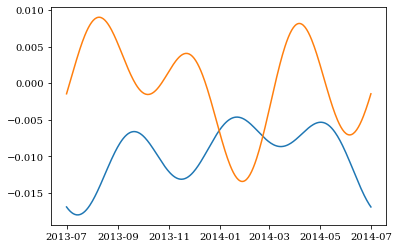

In [6]:
time = pd.date_range('2013-07-01','2014-07-01',freq='D').values

A_re, A_im = sshdriver.extract_amp_nonstat(ssh, np.array([xpt]), np.array([ypt]), time, kind='linear')

plt.figure()
plt.plot(time, A_re[0,...])
plt.plot(time, A_im[0,...])

# Test 4: Interpolate a time-series of slowing varying amplitude onto a line

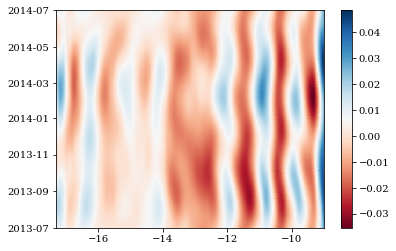

In [7]:
# Lombok to Rowley Shoals line
x1,x2 = 115.6, 119.1
y1,y2 = -9, -17.3
n = 500

# Lombok to Pilbara line
# x1,x2 = 115.6, 115.9
# y1,y2 = -8.8, -18.9
# n = 500

# Timor Sea
# x1,x2 = 126.2, 127.55, 
# y1,y2 = -8.9, -10
# n = 100

# BB line
# x1, x2 = 122.753, 123.486
# y1, y2 = -13.1026, -13.947

# n = 100


# Create a line
tline = np.linspace(0,1,n)
xline = np.linspace(x1,x2,n)
F = interp1d([0,1],[y1,y2], kind='linear')
yline = F(tline)

A_re, A_im = sshdriver.extract_amp_nonstat(ssh, xline, yline, time, kind='linear')

plt.figure()
plt.pcolormesh(yline,time, A_re[1,...], cmap='RdBu')
plt.colorbar()
# plt.plot(time, A_im[1,...])

# Test 5: DFF of a single (complex) array over a region of choice`

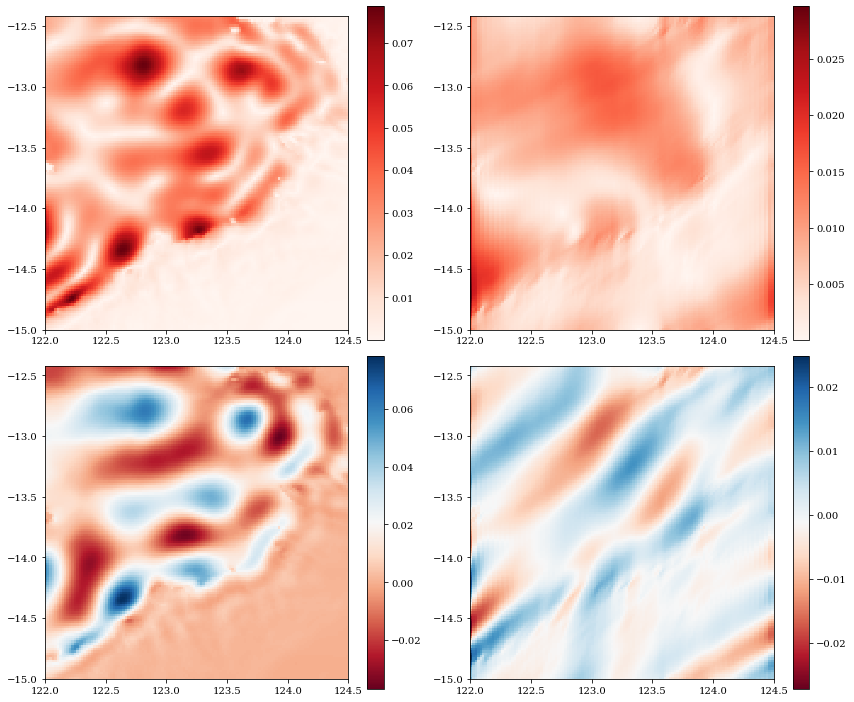

In [8]:
# Interpolate the amplitude onto a grid prior to DFF
###
# xlims = (114,118)
# ylims = (-12,-9.35)

xlims = (122,124.5)
ylims = (-15,-12.43)

dx = 0.02

# Filtering bands (degrees CCW from East)
thetalow = 120
thetahigh = 180

#######

# Interpolate an array onto a regular grid
xx = np.arange(xlims[0], xlims[1]+dx,dx)
yy = np.arange(ylims[0], ylims[1]+dx,dx)
X,Y = np.meshgrid(xx,yy)

ii = 3 # M2 main harmonic = 3, S2 = 10, K1 = 24

z_re = ssh.interpolate(ssh._ds.SSH_BC_Aa[ii,...], X ,Y)
z_im = ssh.interpolate(ssh._ds.SSH_BC_Ba[ii,...], X ,Y)
z = z_re+1j*z_im
zf = dff2d(z, dx, thetalow, thetahigh)

plt.figure(figsize=(12,10))
plt.subplot(221)
plt.pcolormesh(X,Y,np.abs(z), cmap='Reds')
plt.colorbar()
plt.gca().set_aspect('equal')

plt.subplot(222)
plt.pcolormesh(X,Y,np.abs(zf), cmap='Reds')
plt.colorbar()
plt.tight_layout()
plt.gca().set_aspect('equal')

plt.subplot(223)
plt.pcolormesh(X,Y,np.real(z), cmap='RdBu')
plt.colorbar()
plt.gca().set_aspect('equal')

plt.subplot(224)
plt.pcolormesh(X,Y,np.real(zf), cmap='RdBu')
plt.colorbar()
plt.tight_layout()
plt.gca().set_aspect('equal')



# Test 6a: Generate DFF snapshot for a region (slowly-varying amplitude only)

In [9]:

xyrange = 2.5
xlims = (xpt-xyrange, xpt+xyrange)
ylims = (ypt-xyrange, ypt+xyrange)


# Filtering bands (degrees CCW from East)
# thetalow = 270
# thetahigh = 335

# Northward propagating
thetalow = 60
thetahigh = 120

# Southward
thetalow = 270-30.
thetahigh = 270+30.

# SE
thetalow = 315. - 45
thetahigh = 315 + 45.


dx = 0.02

#######

A_re_f, A_im_f, A_re, A_im, X, Y = sshdriver.extract_amp_nonstat_dff(ssh, xlims, ylims, dx, time[[0,180]],\
                    thetalow, thetahigh, A_re=None, A_im=None)

(-16.2641, -11.2641)

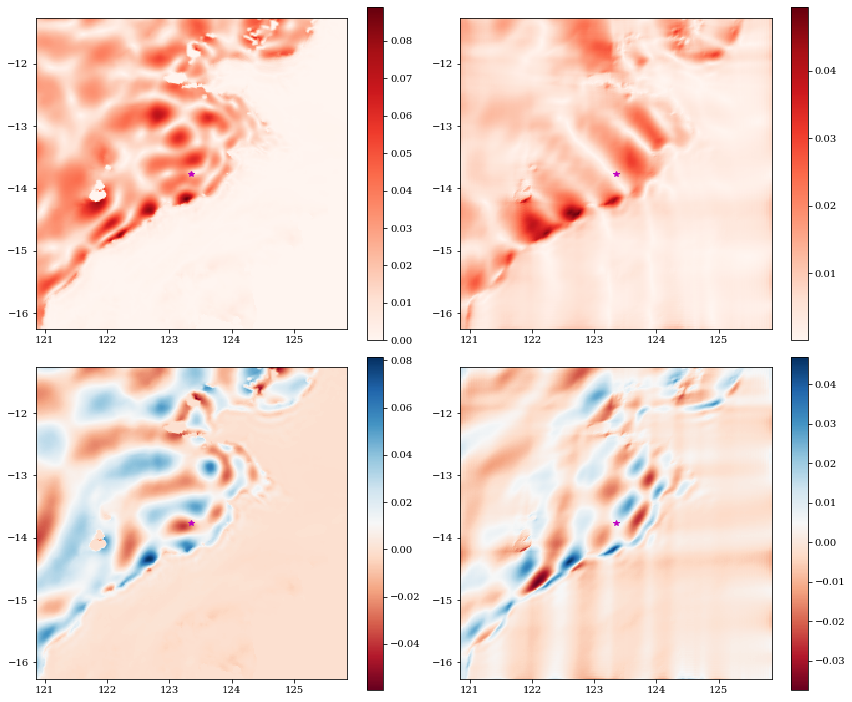

In [10]:
frq=0
z = A_re[frq,0,...] + 1j*A_im[frq,0,...]
zf = A_re_f[frq,0,...] + 1j*A_im_f[frq,0,...]


plt.figure(figsize=(12,10))
plt.subplot(221)
plt.pcolormesh(X,Y,np.abs(z), cmap='Reds')
plt.colorbar()
plt.gca().set_aspect('equal')
plt.plot(xline,yline,'r--')
plt.plot(xpt, ypt, 'm*')
plt.plot(x1,y1,'kd')
plt.xlim(xlims)
plt.ylim(ylims)

plt.subplot(222)
plt.pcolormesh(X,Y,np.abs(zf), cmap='Reds')
plt.colorbar()
plt.tight_layout()
plt.gca().set_aspect('equal')
plt.plot(xline,yline,'r--')
plt.plot(xpt, ypt, 'm*')
plt.plot(x1,y1,'kd')
plt.xlim(xlims)
plt.ylim(ylims)

plt.subplot(223)
plt.pcolormesh(X,Y,np.real(z), cmap='RdBu')
plt.colorbar()
plt.gca().set_aspect('equal')
plt.plot(xline,yline,'r--')
plt.plot(xpt, ypt, 'm*')
plt.plot(x1,y1,'kd')
plt.xlim(xlims)
plt.ylim(ylims)

plt.subplot(224)
plt.pcolormesh(X,Y,np.real(zf), cmap='RdBu')
plt.colorbar()
plt.tight_layout()
plt.gca().set_aspect('equal')
plt.plot(xline,yline,'r--')
plt.plot(xpt, ypt, 'm*')
plt.plot(x1,y1,'kd')
plt.xlim(xlims)
plt.ylim(ylims)



# Test 6b: Generate DFF time-series at a point (whole signal)

In [11]:
# Extract amplitude at a point
dt = 1800
nsteps = 15*86400//dt
tstart = np.datetime64('2017-03-30 00:00:00')
timeout = np.array([tstart+np.timedelta64(ii*dt,'s') for ii in range(nsteps)])

ssh_SE = sshdriver.extract_ssh_point_dff(ssh, xpt, ypt, timeout, 270, 360, xyrange=2.0, dx=0.02 )
ssh_N = sshdriver.extract_ssh_point_dff(ssh, xpt, ypt, timeout, 60, 120, xyrange=2.0, dx=0.02 )

# # Calculate a time series of ssh at the point without DFF
ssh_pt = sshdriver.predict_ssh(ssh, xpt, ypt, timeout)

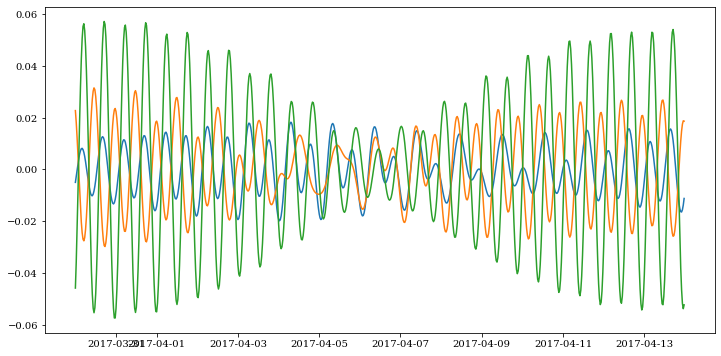

In [12]:
plt.figure(figsize=(12,6))
plt.plot(timeout, ssh_pt)
plt.plot(timeout, ssh_SE)
plt.plot(timeout, ssh_N)

# Test 7: Generate a time-series of $N^2$ at a point

Steps are:

 - Interpolate the N2 parameters onto the point
 - Reconstruct the time-series of parameters at a point
 - Interpolate the water depth and create a vertical grid
 - Calculate $N^2(z)$ on the grid
 - (Optional) Calculate internal wave properties

In [13]:

# dsN2 = sshdriver.load_ssh_clim()
# dsN2

/home/suntans/code/iwatlas/iwatlas/stratification.py:94: RuntimeWarning: divide by zero encountered in log
  zpr = -np.log(zout)


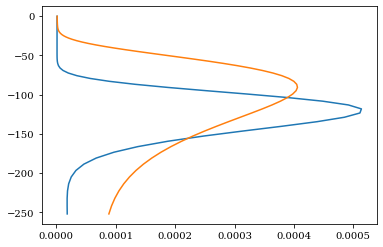

In [14]:
Nz = 80

N2_z, zout = strat.predict_N2(ssh, np.array([xpt]) ,np.array([ypt]), time,  Nz)

# Plot the buoyancy frequency at the first point in space
plt.figure()
plt.plot(N2_z[:,0,0], -zout[:,0,0],)
plt.plot(N2_z[:,0,180], -zout[:,0,180],)



Text(0, 0.5, 'SSH_BC:amplitude ratio')

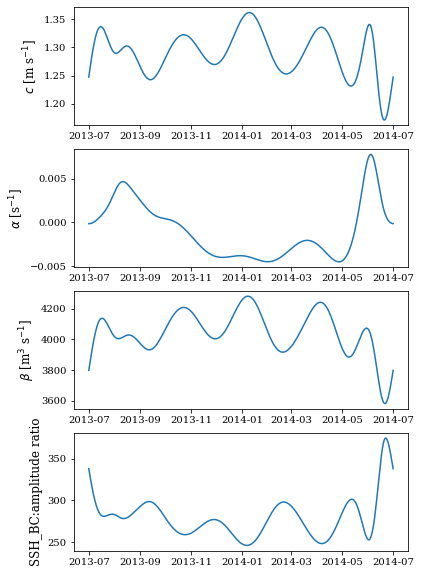

In [15]:
# Calculate the internal wave parameters
mode= 0 
phi_n, cn = iwaves.calc_modes(N2_z, zout, mode=mode)
alpha = iwaves.calc_alpha(phi_n, cn, zout)
beta = iwaves.calc_beta(phi_n, cn, zout)
ampratio = iwaves.ssh_to_amp_ratio(N2_z, phi_n, zout)
sshratio = iwaves.amp_to_ssh_ratio(N2_z, phi_n, zout)

cn.shape
plt.figure(figsize=(6,10))


plt.subplot(411)
plt.plot(time, cn[0,:])
plt.ylabel(r'$c$ [m s$^{-1}$]')

# plt.ylim(1,2)

plt.subplot(412)
plt.plot(time, alpha[0,:])
plt.ylabel(r'$\alpha$ [s$^{-1}$]')
# plt.ylim(-0.012, 0.012)

plt.subplot(413)
plt.plot(time, beta[0,:])
plt.ylabel(r'$\beta$ [m$^3$ s$^{-1}$]')

plt.subplot(414)
plt.plot(time, sshratio[0,:])
plt.ylabel('SSH_BC:amplitude ratio')
# plt.plot(lon, beta[:,1])
# plt.ylim(0,3e4)

---
# More testing

In [31]:
xpt = 121.
ypt = -12.
time = np.array([np.datetime64('2013-06-01 00:00:00'), np.datetime64('2013-09-01 00:00:00')])


#
tsec = (time - np.datetime64('2000-01-01 00:00:00')).astype('timedelta64[s]').astype(float)

# Interpolate the parameters onto the point
ntide = dsN2._ds.dims['Ntide']
nparams = dsN2._ds.dims['Nparams']

N2_mu = np.zeros((nparams,))
N2_re = np.zeros((ntide,nparams))
N2_im = np.zeros((ntide,nparams))

for nn in range(nparams):
    N2_mu[nn] = dsN2.interpolate(dsN2._ds['N2_mu'].values[nn,:], xpt, ypt, kind='nearest')
    for tt in range(ntide):
        N2_re[tt,nn] = dsN2.interpolate(dsN2._ds['N2_re'].values[tt, nn,:], xpt, ypt, kind='nearest')
        N2_im[tt,nn] = dsN2.interpolate(dsN2._ds['N2_im'].values[tt, nn,:], xpt, ypt, kind='nearest')

N2_mu

array([4.02866405e-06, 1.99114830e-04, 4.84362228e+00, 6.96012986e-01,
       4.47245825e+00, 4.16272640e-01])

In [32]:
harmonics.harmonic_pred?
tsec

array([4.233600e+08, 4.313088e+08])

Signature: harmonics.harmonic_pred(aa, Aa, Ba, omega, tdays)
Docstring: <no docstring>
File:      ~/code/iwatlas/iwatlas/harmonics.py
Type:      function


# General code testing below this point

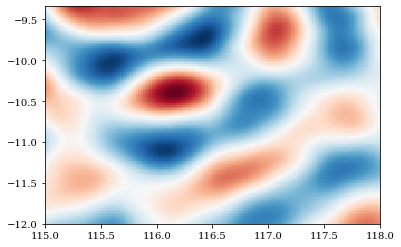

In [183]:
# Interpolate the amplitude onto a grid prior to DFF
###
xlims = (115,118)
ylims = (-12,-9.35)
dx = 0.02

time = np.array([np.datetime64('2013-06-01 00:00:00')])

# Filtering bands (degrees CCW from East)
thetalow = 0
thetahigh = 180.
####

xgrd  = np.arange(xlims[0], xlims[1]+dx, dx)
ygrd  = np.arange(ylims[0], ylims[1]+dx, dx)
X,Y = np.meshgrid(xgrd, ygrd)
My, Mx = X.shape

# Interpolate (need to flatten the spatial dimension)
A_re, A_im = extract_amp_nonstat(ssh, X.ravel(), Y.ravel(), time, kind='linear')

ntide, ntime, ss = A_re.shape
A_re = A_re.reshape((ntide, ntime, My, Mx))
A_im = A_im.reshape((ntide, ntime, My, Mx))

plt.figure()
plt.pcolormesh(X,Y,A_re[0,0,...], cmap='RdBu')


z = A_re[0,0,...] + 1j*A_im[0,0,...]

# 2D fourier transfrom
My, Mx = z.shape
Z = fft2(z)

# Compute zonal frequencies
k = fftfreq(Mx, dx/(2*np.pi))
dk = 1/(Mx*dx)

# Compute meridional frequencies
l = fftfreq(My, dx/(2*np.pi))
dl = 1/(My*dx)

In [136]:
My, Mx, l

(134, 151, array([   0.        ,    2.34447213,    4.68894426,    7.03341639,
           9.37788852,   11.72236065,   14.06683278,   16.41130491,
          18.75577704,   21.10024917,   23.4447213 ,   25.78919342,
          28.13366555,   30.47813768,   32.82260981,   35.16708194,
          37.51155407,   39.8560262 ,   42.20049833,   44.54497046,
          46.88944259,   49.23391472,   51.57838685,   53.92285898,
          56.26733111,   58.61180324,   60.95627537,   63.3007475 ,
          65.64521963,   67.98969176,   70.33416389,   72.67863602,
          75.02310815,   77.36758027,   79.7120524 ,   82.05652453,
          84.40099666,   86.74546879,   89.08994092,   91.43441305,
          93.77888518,   96.12335731,   98.46782944,  100.81230157,
         103.1567737 ,  105.50124583,  107.84571796,  110.19019009,
         112.53466222,  114.87913435,  117.22360648,  119.56807861,
         121.91255074,  124.25702287,  126.601495  ,  128.94596712,
         131.29043925,  133.63491138, 

In [137]:
# k.shape

In [138]:
# lx,ly = np.meshgrid(k,l)
# theta = np.angle(lx + 1j*ly)
# theta

In [139]:
# # Create a grid for the direction

# plt.figure()
# plt.pcolormesh(lx,ly,theta*180/np.pi, cmap='jet')
# plt.colorbar()


In [140]:
k.shape, Mx, l.shape, My

((151,), 151, (134,), 134)

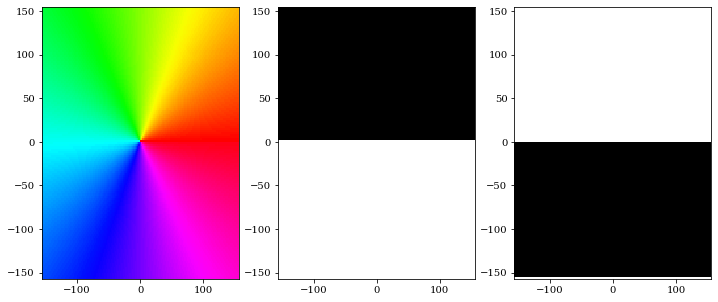

In [184]:
# Need to re-order the FFT output because positive frequencies are output first from the numpy DFT algorithm
# k_r = np.zeros_like(k)

# k_r[0:Mx//2] = k[Mx//2+1::] #[::-1] # Reverse the negative frequencies
# k_r[Mx//2+1::] = k[1:Mx//2+1] #[::-1]

# l_r = np.zeros_like(l)

# l_r[0:My//2] = l[My//2+1::] #[::-1] # Reverse the negative frequencies
# l_r[My//2+1::] = l[1:My//2+1] #[::-1]
k_r = fftshift(k)
l_r = fftshift(l)

# Create a grid for the direction
Lx,Ly = np.meshgrid(k_r,l_r)
theta = np.angle(Lx + 1j*Ly)

thetadeg = np.mod(theta*180/np.pi,360)

# Create the filter matrix
H = np.zeros_like(thetadeg)
filter_idx = (thetadeg > thetalow) & (thetadeg < thetahigh)
H[filter_idx] = 1

# Now reorder H into the original FFT ordering
H_r = np.zeros_like(H)

# Bottom half of matrix
#H_r[0:My//2, 0:Mx//2] = H[0:My//2,Mx//2+1::] #[::-1] # Reverse the negative frequencies
#H_r[0:My//2,Mx//2+1::] = H[0:My//2,1:Mx//2+1] #[::-1]

# Top Half
#H_r[My//2+1::, 0:Mx//2] = H[My//2+1::,Mx//2+1::] #[::-1] # Reverse the negative frequencies
#H_r[My//2+1::,Mx//2+1::] = H[My//2+1::,1:Mx//2+1] #[::-1]
H_r = ifftshift(H,axes=0)
H_r = ifftshift(H_r,axes=1)


# Filter
zf = ifft2(Z*H_r)


plt.figure(figsize=(12,5))
plt.subplot(131)
plt.pcolormesh(Lx,Ly, thetadeg, cmap='hsv')

plt.subplot(132)
plt.pcolormesh(Lx,Ly, H, cmap='Greys')

plt.subplot(133)
plt.pcolormesh(Lx,Ly, H_r, cmap='Greys')

In [177]:
fftshift(l)

array([-157.07963268, -154.73516055, -152.39068842, -150.04621629,
       -147.70174416, -145.35727203, -143.0127999 , -140.66832777,
       -138.32385564, -135.97938351, -133.63491138, -131.29043925,
       -128.94596712, -126.601495  , -124.25702287, -121.91255074,
       -119.56807861, -117.22360648, -114.87913435, -112.53466222,
       -110.19019009, -107.84571796, -105.50124583, -103.1567737 ,
       -100.81230157,  -98.46782944,  -96.12335731,  -93.77888518,
        -91.43441305,  -89.08994092,  -86.74546879,  -84.40099666,
        -82.05652453,  -79.7120524 ,  -77.36758027,  -75.02310815,
        -72.67863602,  -70.33416389,  -67.98969176,  -65.64521963,
        -63.3007475 ,  -60.95627537,  -58.61180324,  -56.26733111,
        -53.92285898,  -51.57838685,  -49.23391472,  -46.88944259,
        -44.54497046,  -42.20049833,  -39.8560262 ,  -37.51155407,
        -35.16708194,  -32.82260981,  -30.47813768,  -28.13366555,
        -25.78919342,  -23.4447213 ,  -21.10024917,  -18.75577

In [179]:
idx = np.argsort(l)
idx

array([ 67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
        11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
        24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
        37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66])

TypeError: Dimensions of C (134, 151) are incompatible with X (126) and/or Y (130); see help(pcolormesh)

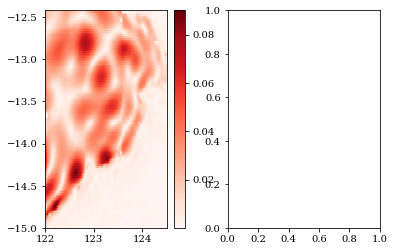

In [182]:
plt.figure()
plt.subplot(121)
plt.pcolormesh(X,Y,np.abs(z), cmap='Reds')
plt.colorbar()

plt.subplot(122)
plt.pcolormesh(X,Y,np.abs(zf), cmap='Reds')
plt.colorbar()
plt.tight_layout()

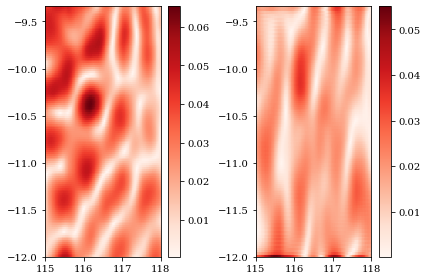

In [147]:
z = A_re[0,0,...] + 1j*A_im[0,0,...]
#zf = dff2d(z, dx, 45,135)
zf = dff2d(z, dx, 225,315)


plt.figure()
plt.subplot(121)
plt.pcolormesh(X,Y,np.abs(z), cmap='Reds')
plt.colorbar()

plt.subplot(122)
plt.pcolormesh(X,Y,np.abs(zf), cmap='Reds')
plt.colorbar()
plt.tight_layout()